In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay-travel cluster classification in 1D: homebrew

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller

## Meth

1. Cut the trajectory into coarse sections
    * do forward and backward, with different epsilons
2. for each of the cut sections,
    1. remove the outliers with IQR
    2. refine the sections with the matrix minimum $\to$ identify as "stays"
3. al non-stays are travels

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

## Make the artificial data: 1D1T

**note** "T" here means just the index; later, it could be considered "time"

# Sythetic data

In [7]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.trajectory_class import get_trajectory

dsec = 1/3600.0
time = np.arange(0,24,dsec)
'''stays = [
        get_stay(  0.00,  6.40,-1.00), #home
        get_stay(  6.50, 17.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]'''

stays = [
        get_stay(  0,  6.40,  1),
        get_stay( 6.50,  18.0, -0.5),
        get_stay( 18.1,  19.5,  0.5),
        get_stay( 19.6,  20.9,  2.5),
        get_stay( 21.0, 24,  1)
    ]


configs = {
    'threshold':0.5,
    'event_frac':0.05,
    'duplicate_frac':0.3,    
    'noise_min':0.02,
    'noise_max':0.15
}


time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

In [8]:
noise_journey_sub.size

4319

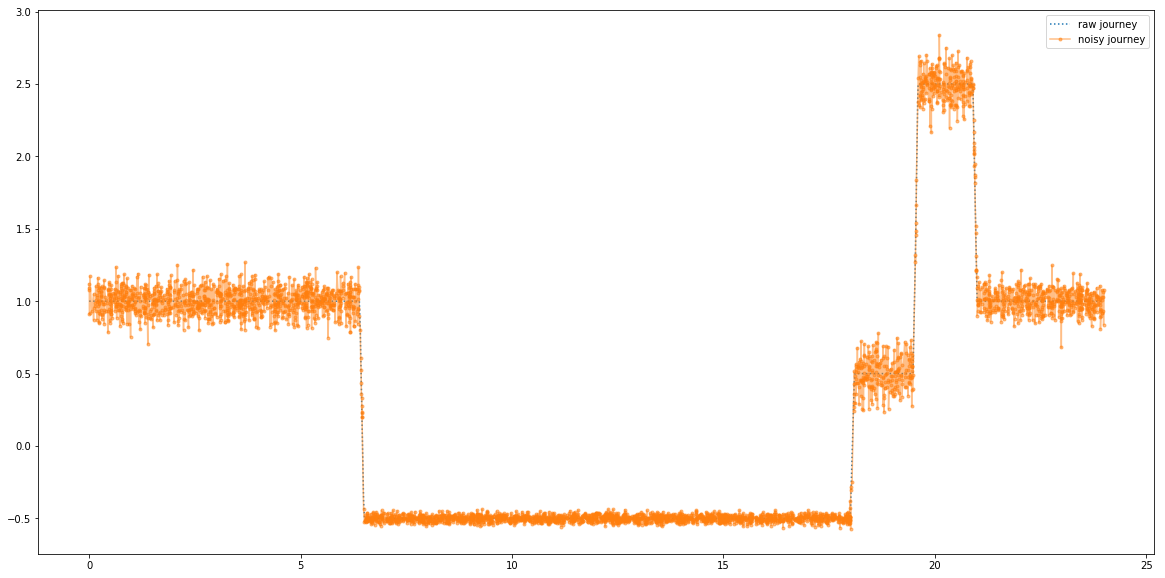

In [9]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend();

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [10]:
time_thresh = 1/12.
eps=0.25

In [11]:
clusters = list(range(noise_journey_sub.size))

In [12]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2) 

In [13]:
def get_clusters(times, positions, dist_thresh, time_thresh):

    # The list of found clusters
    clusters = []

    # index var.
    m = 0
    
    # 
    new_cluster = []
    for n in range(0,positions.size-3):

        # Check temporal connectedness: look for breaks in the time > thresh
        if times[n+1] <= times[n]+time_thresh:

            get_y = positions[n+1]

        else: 
            continue

        # Check spatial connectedness:
        # Get the current cluster mean
        cluster_mean = np.mean(positions[m:n+1])

        # Get the potential cluster mean    
        new_cluster_mean = np.mean(positions[m:n+2])

        err1 = get_err(cluster_mean, get_y)
        err2 = get_err(cluster_mean, new_cluster_mean)

        #print(n, err1, err2, dist_thresh)

        if  (err1 < dist_thresh) & (err2 < dist_thresh) & \
            (n <= positions.size-5):

            new_cluster.append(n)
            #print(len(new_cluster))
        else:
            txt = f'Trying {n} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            #print(txt+app)

            new_cluster = []

            m=n+1
            
    return clusters

In [14]:
clusters = get_clusters(time_sub, noise_journey_sub, eps, time_thresh)
len(clusters)

20

for clust in clusters:
    print(clust)

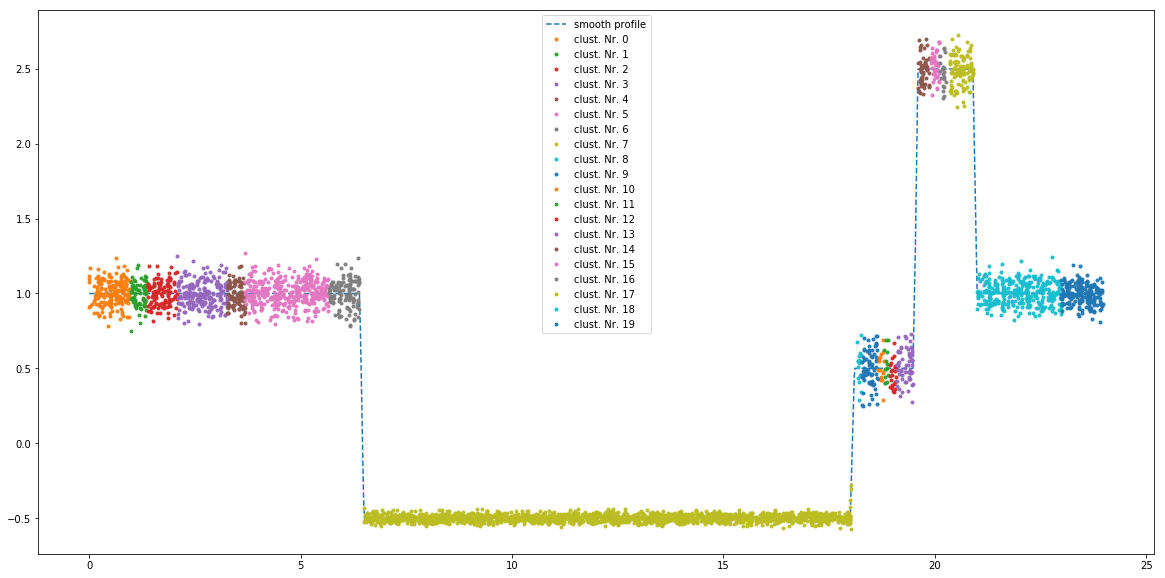

In [15]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')

for cl_nr, clust in enumerate(clusters):
    plt.plot(time_sub[clust], noise_journey_sub[clust], '.', alpha=0.95, label=f'clust. Nr. {cl_nr}')

plt.legend();

```
# Calculate first and third quartile
# the the quantiled std
q25 = np.quantile(time_sub[m:nn],0.25, interpolation='lower')
q75 = np.quantile(time_sub[m:nn],0.75, interpolation='higher')

# Interquartile range
iqr = q75 - q25

# Remove outliers
q75_ind = np.max(np.where(time_sub[m:nn] < (q75 + 3 * iqr)))
q25_ind = np.min(np.where(time_sub[m:nn] > (q25 - 3 * iqr)))
```

In [16]:
m=0
nn=117
q25 = np.quantile(noise_journey_sub[m:nn],0.25, interpolation='lower')
q75 = np.quantile(noise_journey_sub[m:nn],0.75, interpolation='higher')

print(np.quantile(noise_journey_sub[m:nn],[0.25, 0.5, 0.75], interpolation='higher'))
#print()

#print(np.sort(noise_journey_sub[m:nn]))
# Interquartile range

iqr = abs(q75 - q25)
iqr_fact = 3

print()
print(q25, q75, iqr,(q25 - iqr_fact * iqr), (q75 + iqr_fact * iqr))
iqr_fact = 0
print(m, nn, np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr))))
mask=np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr)))
print(noise_journey_sub[m:nn].size, np.std(noise_journey_sub[m:nn]),noise_journey_sub[mask].size, np.std(noise_journey_sub[mask]))

[0.93639255 1.0043702  1.06613788]

0.9363925483282053 1.066137879449519 0.1297453311213138 0.5471565549642639 1.4553738728134604
0 117 (array([  7,   9,  10,  11,  14,  15,  17,  18,  20,  23,  25,  26,  28,
        33,  36,  37,  38,  39,  41,  47,  48,  49,  51,  56,  57,  59,
        64,  65,  66,  70,  73,  74,  76,  77,  78,  80,  81,  83,  88,
        90,  91,  92,  93,  94,  95,  97,  99, 101, 102, 104, 106, 107,
       109, 110, 111, 114, 115]),)
117 0.08247431007555087 57 0.03331506187925971


In [17]:
def get_iqr_masked(positions, iqr_fact = 3):
    # Calculate first and third quartiles
    q25 = np.quantile(positions,0.25, interpolation='lower')
    q75 = np.quantile(positions,0.75, interpolation='higher')

    # Calculate the interquartile range (IQR)
    iqr = abs(q75 - q25)

    #print(m, nn, np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr))))
    mask=np.where(  (positions > (q25 - iqr_fact * iqr)) \
                  & (positions < (q75 + iqr_fact * iqr)))    
    
    return mask

def get_iqr_std(positions, iqr_fact = 3):
    
    if len(positions) > 1:

        mask=get_iqr_masked(positions, iqr_fact)
    
        return np.std(positions[mask])
    else:
        return positions[0]

def get_iqr_avg(positions, iqr_fact = 3):
    
    if len(positions) > 1:

        mask=get_iqr_masked(positions, iqr_fact)
    
        return np.mean(positions[mask])
    else:
        return positions[0]

In [18]:
def get_batch_clusters(times, positions, dist_thresh, time_thresh):

    # Get the max length of any cluster
    max_len = positions.size-6
    
    # The list of found clusters
    clusters = []

    # global indexing var
    ind = 0
    
    # Current cluster: a list of indices
    cluster = [0]
    
    # the last time point of a given cluster
    last_time_point = times[cluster[0]]

    # local indexing var
    m = 0 
    
    # iterate through the elements
    while ind < max_len:

        
        # Set the time buffer around the last point of the current cluster
        # look for the next temporally connected event
        # NOTE: _all_ events can be connected if the samp. freq. is high enough!
        # TODO: try something else!!!
        nn=m+1
        while (times[nn]-last_time_point <= time_thresh) & (nn<=max_len):
            nn+=1

        #print(m,nn, positions[m:nn].shape)
        
        if positions[m:nn].size > 1:
            
            # Get the current cluster std
            cluster_std = np.std(positions[m:nn])
            cluster_qstd = get_iqr_std(positions[m:nn])
            
        else:
            cluster_std = 0.0
            cluster_qstd = 0.0
        
        nnn=nn
        while ((positions[m:nnn].size > 1) & ((cluster_std >= dist_thresh) | (cluster_qstd >= dist_thresh))):
            print('\t\trefinement', nnn, cluster_std, cluster_qstd)
            # Get the current cluster std
            cluster_std = np.std(positions[m:nnn])
            cluster_qstd = get_iqr_std(positions[m:nnn])
            nnn-=1

        # Check!
        print('STD-testing at', nn, cluster_std, cluster_qstd, dist_thresh)
        # 
        new_cluster = list(range(m,nnn+1))

        # if the std's are good, keep the cluster, and update the final time point
        if  (cluster_std < dist_thresh) & (cluster_qstd < dist_thresh) & (nnn<max_len) & (nnn==nn) :

            last_time_point = times[nnn]
            ind = nnn

        else:
            txt = f'Trying {len(new_cluster)} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            print(txt+app)

            new_cluster = []
            if (nnn==nn):
                ind=nn
                m=nn
            else:
                ind=nnn
                m=nnn
            
    return clusters

In [19]:
get_normd_err = lambda x,mu,thresh: ((x-mu)/thresh)
get_norm_diff = lambda diff,denom: diff/denom
norm  = lambda vals :np.linalg.norm([vals])

In [20]:
def get_batch_clusters2(times, locs, dist_thresh, time_thresh):

    
    # Get the max length of any cluster
    max_len = locs.size-6
    
    # The list of found clusters
    clusters = []

    # global indexing var
    ind = 0
    
    # Current cluster: a list of indices
    cluster = [0]
    
    # the last time point of a given cluster
    last_time_point = times[cluster[0]]

    # local indexing var
    m = 0 
    
    # iterate through the elements
    continuing = True
    while continuing:
        
        # Get a primitive cluster
        nn=m+1
        last_time_point = times[m]
        check_norm = True
        while check_norm:

            # Some statistics: std, IQR-std, IQR-mean
            cluster_std = np.std(locs[m:nn])
            cluster_avg = np.mean(locs[m:nn])
            cluster_qstd = get_iqr_std(locs[m:nn])            
            cluster_qavg = get_iqr_avg(locs[m:nn])            

            #print(locs[m:nn],cluster_std,locs[nn])
            # Some local info: current x,t
            tval  = get_norm_diff(times[nn]-last_time_point, time_thresh)

            next_loc =locs[nn]
            x1val = 0.0 #get_norm_diff(locs[nn]-cluster_avg,  dist_thresh)   
            x2val = get_norm_diff(next_loc-cluster_qavg, dist_thresh)   
            s1val = 0.0 #get_norm_diff(locs[nn]-cluster_std,  dist_thresh)
            s2val = get_norm_diff(next_loc-cluster_qstd, dist_thresh)

            the_norm1 = norm([x2val,tval])
            the_norm2 = norm([x1val,x2val,s1val,s2val,tval])

            print(x1val,x2val,s1val,s2val,tval,the_norm1,the_norm2, len(locs[m:nn]))

            check_norm = the_norm2 < 1

            if check_norm:
                last_time_point = times[nn]
                nn+=1
        clusters.append([m,nn])
        print([m,nn])
        m=nn
        continuing = m < max_len
        
    return clusters

In [21]:
np.sqrt(2*((0.5)**2))

0.7071067811865476

In [22]:
((1-np.mean([1,2]))**2)+((2-np.mean([1,2]))**2)

0.5

In [23]:
np.sqrt(np.std([1,2]))

0.7071067811865476

### the metrics: what changes and how

In [24]:
m = 0
nn = 1
columns=['t', 'x', 'dt', 'm1', 'm2', 'd1', 'qd', 's1', 'qs', 's1n', 'qsn']
pdf_traj = pd.DataFrame(columns=columns)
last_time_point = time_sub[0]
for _ in range(len(noise_journey_sub)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_sub[m:nn])
    cluster_avg = np.mean(noise_journey_sub[m:nn])
    cluster_qstd = get_iqr_std(noise_journey_sub[m:nn+1])            
    cluster_qavg = get_iqr_avg(noise_journey_sub[m:nn+1])            

    #print(noise_journey_sub[m:nn],cluster_std,noise_journey_sub[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_sub[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_sub[nn]
    x1val = get_norm_diff(next_loc-cluster_avg,  eps)   
    x2val = get_norm_diff(next_loc-cluster_qavg, eps)   
    s1val = get_norm_diff(cluster_std,  eps)
    s2val = get_norm_diff(cluster_qstd, eps)

    
    pdf_ = pd.DataFrame(data=[[time_sub[nn],noise_journey_sub[nn],
                         tval, x1val, x2val, cluster_avg, cluster_qavg,
                         s1val, s2val, cluster_std, cluster_qstd]],
                           columns=columns)
    pdf_traj = pd.concat([pdf_traj, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_sub[nn]
    if s1val > 1.0:
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))

pdf_traj.reset_index(drop=True, inplace=True)

In [25]:
pdf_traj.head(20)

,t,x,dt,m1,m2,d1,qd,s1,qs,s1n,qsn
0,0.005000,1.075902,0.030000,-0.174430,-0.087215,1.119509,1.097705,0.000000,0.087215,0.000000,0.021804
1,0.005556,1.093531,0.006667,-0.016698,-0.011132,1.097705,1.096314,0.087215,0.071644,0.021804,0.017911
2,0.006944,0.909456,0.016667,-0.747433,-0.560575,1.096314,1.049599,0.071644,0.329542,0.017911,0.082385
3,0.015833,0.918672,0.106667,-0.523709,-0.418967,1.049599,1.023414,0.329542,0.361609,0.082385,0.090402
4,0.019722,1.173431,0.046667,0.600069,0.500057,1.023414,1.048417,0.361609,0.398722,0.090402,0.099681
5,0.060833,0.929798,0.493333,-0.474475,-0.406693,1.048417,1.031471,0.398722,0.404765,0.099681,0.101191
6,0.105833,1.049363,0.540000,0.071569,0.062623,1.031471,1.033708,0.404765,0.379362,0.101191,0.094840
7,0.105833,0.869721,0.000000,-0.655946,-0.583063,1.033708,1.015487,0.379362,0.412820,0.094840,0.103205
8,0.105833,0.952616,0.000000,-0.251483,-0.226335,1.015487,1.009200,0.412820,0.398836,0.103205,0.099709
9,0.139722,0.985269,0.406667,-0.095726,-0.087023,1.009200,1.007024,0.398836,0.381269,0.099709,0.095317


In [26]:
pdf_traj.reset_index(drop=True, inplace=True)

In [27]:
m = 0
nn = 1

noise_journey_subr = noise_journey_sub[::-1]
time_subr = time_sub[::-1]


columns=['t', 'x', 'dt', 'm1', 'm2', 'd1', 'qd', 's1', 'qs', 's1n', 'qsn']
pdf_trajr = pd.DataFrame(columns=columns)
last_time_point = time_subr[0]
for _ in range(len(noise_journey_sub)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_subr[m:nn])
    cluster_avg = np.mean(noise_journey_subr[m:nn])
    cluster_qstd = get_iqr_std(noise_journey_subr[m:nn+1])            
    cluster_qavg = get_iqr_avg(noise_journey_subr[m:nn+1])            

    #print(noise_journey_subr[m:nn],cluster_std,noise_journey_subr[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_subr[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_subr[nn]
    x1val = get_norm_diff(next_loc-cluster_avg,  eps)   
    x2val = get_norm_diff(next_loc-cluster_qavg, eps)   
    s1val = get_norm_diff(cluster_std,  eps)
    s2val = get_norm_diff(cluster_qstd, eps)

    
    pdf_ = pd.DataFrame(data=[[time_subr[nn],noise_journey_subr[nn],
                         tval, x1val, x2val, cluster_avg, cluster_qavg,
                         s1val, s2val, cluster_std, cluster_qstd]],
                           columns=columns)
    pdf_trajr = pd.concat([pdf_trajr, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_subr[nn]
    if s1val > 1.0:
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_subr[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_subr[m:nn]))

pdf_trajr.reset_index(drop=True, inplace=True)

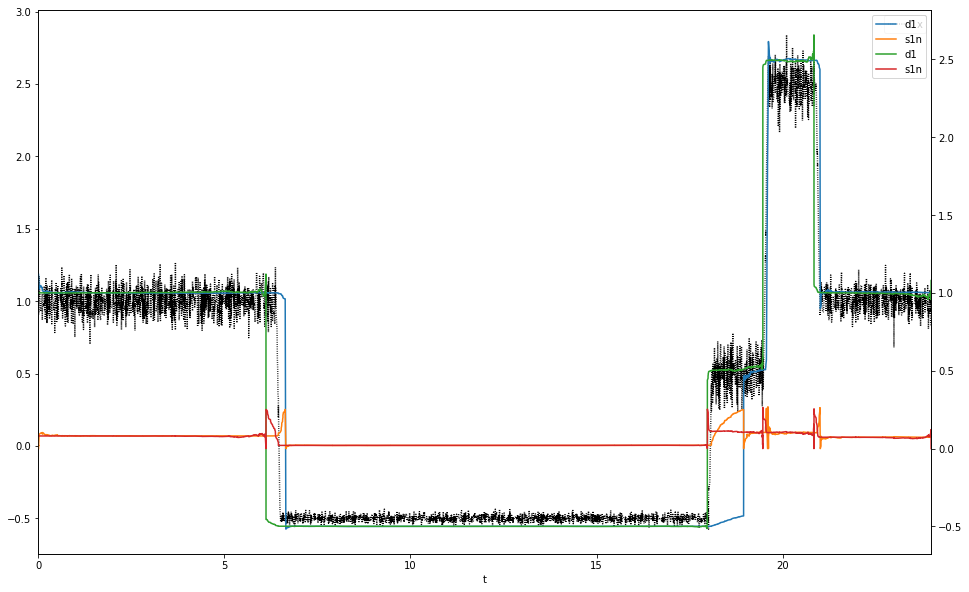

In [28]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t',y=['d1','s1n'],  ax=axt)
pdf_trajr.plot(x='t',y=['d1','s1n'],  ax=axt)
axt.legend()

(-0.002, 0.5)

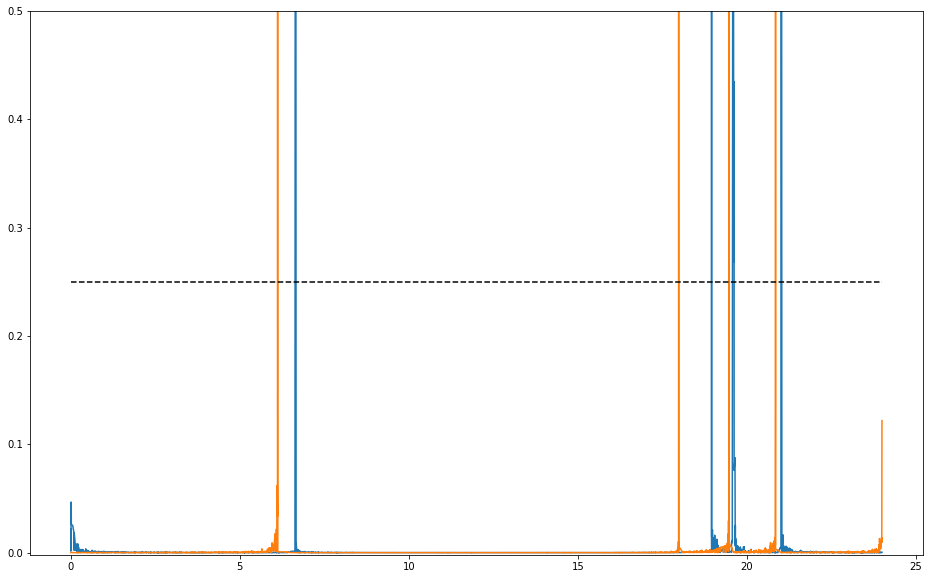

In [34]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.plot(pdf_traj.t.values[1:], abs(pdf_traj.d1.values[1:]-pdf_traj.d1.values[0:-1]))
ax.plot(pdf_trajr.t.values[0:-1], abs(pdf_trajr.d1.values[1:]-pdf_trajr.d1.values[0:-1]))
ax.plot([0,24], [eps,eps], 'k--')
ax.set_ylim([-0.002,0.5])
#ax.set_xlim([5.9,7]);

In [29]:
pdf_traj.t.values[1:]
fdiffs = abs(pdf_traj.d1.values[1:]-pdf_traj.d1.values[0:-1])

pdf_trajr.t.values[0:-1]
bdiffs = abs(pdf_trajr.d1.values[1:]-pdf_trajr.d1.values[0:-1])

fdiffs_mask = np.where(fdiffs > eps)
bdiffs_mask = np.where(bdiffs > eps)



In [30]:
m = 0
nn = 1
columns=['t', 'x','s1', 's2', 's3', 's4']
pdf_traj = pd.DataFrame(columns=columns)
last_time_point = time_sub[0]
for _ in range(len(noise_journey_sub)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_sub[m:nn])
    cluster_avg = np.mean(noise_journey_sub[m:nn])       

    #print(noise_journey_sub[m:nn],cluster_std,noise_journey_sub[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_sub[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_sub[nn]
    
    s1 = get_norm_diff(cluster_std,  0.25*eps)
    s2 = get_norm_diff(cluster_std,  0.5*eps)
    s3 = get_norm_diff(cluster_std,  1.0*eps)
    s4 = get_norm_diff(cluster_std,  2.0*eps)
    
    pdf_ = pd.DataFrame(data=[[time_sub[nn],next_loc,s1,s2,s3,s4]],
                         columns=columns)
    pdf_traj = pd.concat([pdf_traj, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_sub[nn]
    if s3 > 1.0:
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))

pdf_traj.reset_index(drop=True, inplace=True)

In [31]:
noise_journey_subr = noise_journey_sub[::-1]
time_subr = time_sub[::-1]

m = 0
nn = 1
columns=['t', 'x','s1', 's2', 's3', 's4']
pdf_trajr = pd.DataFrame(columns=columns)
last_time_point = time_subr[0]
for _ in range(len(noise_journey_subr)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_subr[m:nn])
    cluster_avg = np.mean(noise_journey_subr[m:nn])       

    #print(noise_journey_sub[m:nn],cluster_std,noise_journey_sub[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_subr[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_subr[nn]
    
    s1 = get_norm_diff(cluster_std,  0.25*eps)
    s2 = get_norm_diff(cluster_std,  0.5*eps)
    s3 = get_norm_diff(cluster_std,  1.0*eps)
    s4 = get_norm_diff(cluster_std,  2.0*eps)
    
    pdf_ = pd.DataFrame(data=[[time_subr[nn],next_loc,s1,s2,s3,s4]],
                         columns=columns)
    pdf_trajr = pd.concat([pdf_trajr, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_subr[nn]
    if s3 > 1.0:
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))

pdf_trajr.reset_index(drop=True, inplace=True)

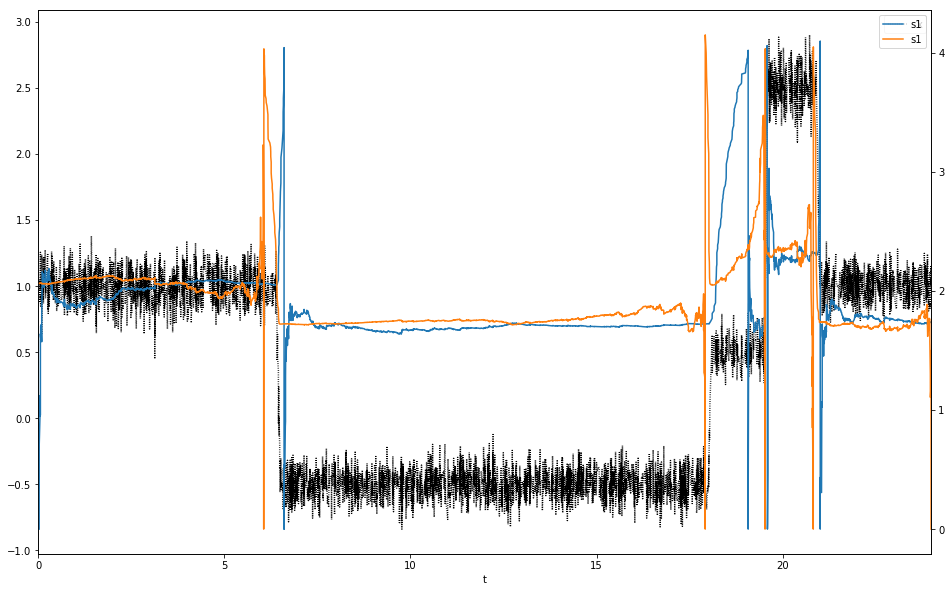

In [32]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t', y=['s1'], ax=axt)
pdf_trajr.plot(x='t', y=['s1'], ax=axt)
axt.legend()

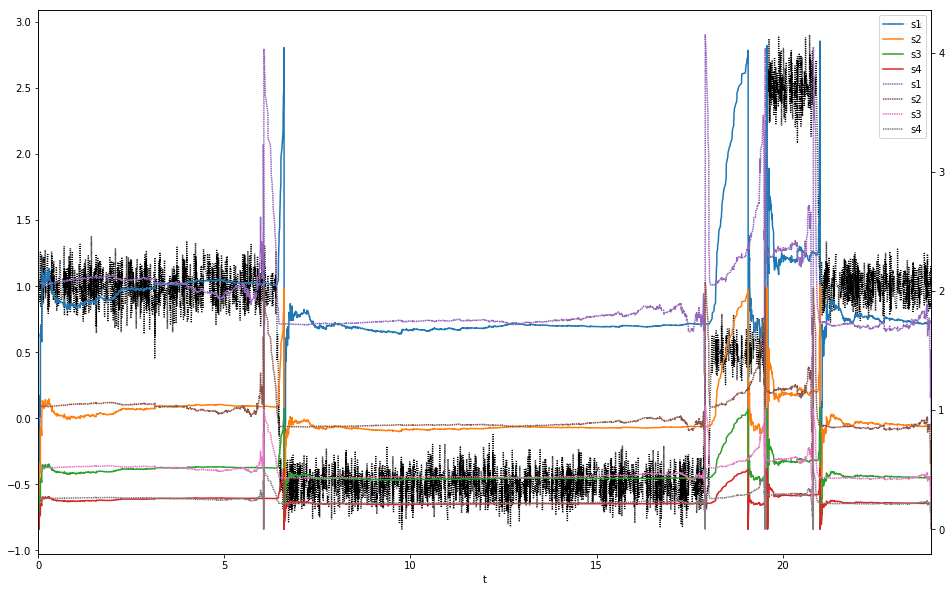

In [33]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

colors=['C1','C1','C2','C4'], 


pdf_traj.plot(x='t', y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t', y=['s1','s2','s3','s4'],  ax=axt)
pdf_trajr.plot(x='t', y=['s1','s2','s3','s4'], dashes=[1,0.5], ax=axt)
axt.legend()

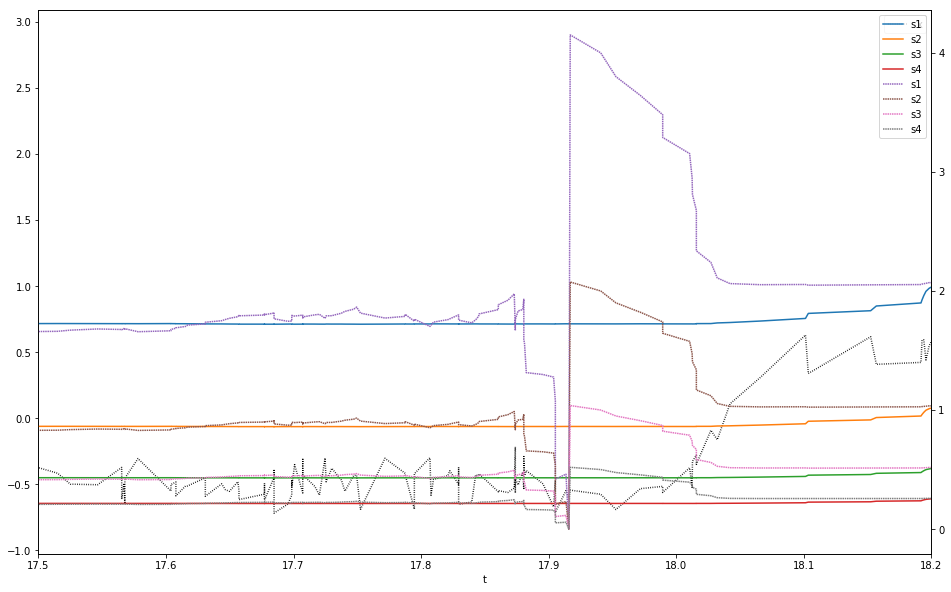

In [145]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

colors=['C1','C1','C2','C4'], 


pdf_traj.plot(x='t', y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t', y=['s1','s2','s3','s4'],  ax=axt)
pdf_trajr.plot(x='t', y=['s1','s2','s3','s4'], dashes=[1,0.5], ax=axt)
axt.legend()
plt.xlim([17.5,18.2]);

No handles with labels found to put in legend.


(5, 24)

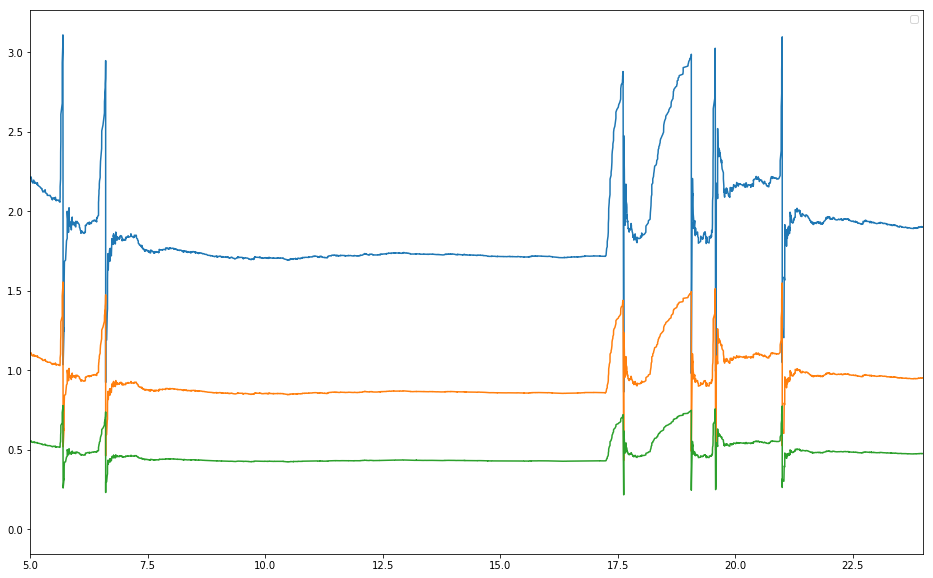

In [34]:
fig, axt = plt.subplots(1,1,figsize=[16,10])

colors=['C1','C1','C2','C4'], 

'''pdf_traj.plot(x='t', y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
'''#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
#pdf_traj.plot(x='t', y=['s1'],  ax=axt)
#pdf_trajr.plot(x='t', y=['s1'], dashes=[1,0.5], ax=axt)

plt.plot(pdf_traj.t.values, abs(pdf_traj.s1.values + pdf_trajr.s1.values)/2)
plt.plot(pdf_traj.t.values, abs(pdf_traj.s2.values + pdf_trajr.s2.values)/2)
plt.plot(pdf_traj.t.values, abs(pdf_traj.s3.values + pdf_trajr.s3.values)/2)

axt.legend()
plt.xlim([5,24])
#ax.set_ylim([-1.0, 1.5])
#axt.set_ylim([-1.0, 5.0])

In [146]:
pdf_traj[(pdf_traj['t']>=17.8) & (pdf_traj['t']<18.1)]

,t,x,s1,s2,s3,s4
3262,17.806944,-0.298655,1.722171,0.861086,0.430543,0.215271
3263,17.807778,-0.581690,1.723180,0.861590,0.430795,0.215397
3264,17.809722,-0.463250,1.723015,0.861507,0.430754,0.215377
3265,17.821111,-0.433172,1.722645,0.861322,0.430661,0.215331
3266,17.822500,-0.397653,1.722382,0.861191,0.430595,0.215298
3267,17.829444,-0.500588,1.722329,0.861164,0.430582,0.215291
3268,17.829444,-0.369829,1.721916,0.860958,0.430479,0.215239
3269,17.829444,-0.651470,1.722089,0.861045,0.430522,0.215261
3270,17.839722,-0.633120,1.722514,0.861257,0.430629,0.215314
3271,17.842778,-0.429295,1.722750,0.861375,0.430688,0.215344


In [ ]:
pdf_traj[(pdf_traj['t']>=6.6) & (pdf_traj['t']<7.0)]

In [ ]:
1184

In [36]:
pdf_traj.head(80).tail(10)

,t,x,s1,s2,s3,s4
70,0.410833,1.129956,1.985297,0.992648,0.496324,0.248162
71,0.410833,1.157815,1.982591,0.991296,0.495648,0.247824
72,0.410833,1.022317,1.985703,0.992851,0.496426,0.248213
73,0.413333,1.124907,1.972241,0.986120,0.493060,0.246530
74,0.417500,1.102807,1.968238,0.984119,0.492060,0.246030
75,0.421389,1.181974,1.960685,0.980342,0.490171,0.245086
76,0.421667,1.106308,1.968867,0.984434,0.492217,0.246108
77,0.424722,0.969146,1.961556,0.980778,0.490389,0.245194
78,0.433333,1.074572,1.951838,0.975919,0.487959,0.243980
79,0.434167,0.904019,1.941507,0.970754,0.485377,0.242688


### Matrix method: find the min

**Note** can't just use matrix method

* Matrix method is huge, at least $\mathcal{O}(N^2)$
* Need to have limits on the ranges in space and time, which is the point of the method to find these ranges $\to$ iteratively
    * having pre-determined values count introduce softer penalities
* matrix elem $M_{ij}$ is a scalar from $x_i, x_j, t_i, t_j$ but $t_{j-n}=\dots=t_{j+m}$ since there are duplicated timepoints
    * this could identify which of those duplicates to keep, but in general all timepoints should be disticnct

In [121]:
from sklearn.model_selection import GridSearchCV

In [37]:
#tdiff_ = lambda t1,t2: ((t2-t1)-(t2-t1)%time_thresh)
#tdiff_ = lambda t1,t2: (t2-t1)%time_thresh
tdiff = lambda t1,t2: time[-1]/tdiff_(t1,t2) if tdiff_(t1,t2)!=0 else time[-1]/dsec

In [38]:
from scipy.sparse import csr_matrix, lil_matrix

In [41]:
from time import time

In [65]:
def s_metric(std, std_max, std_min):
    
    if std > std_max:
        std = min(std,std_max)
    elif std < std_min:
        std = max(std,std_min)
    else:
        pass
    
    return std #/(std_max-std_min)
    

In [66]:
rrr = np.random.random(100)
yyr = np.array(list(map(lambda x: s_metric(x, 1.0, 0.0), rrr)))
yrr = np.array(list(map(lambda x: s_metric(x, 0.6, 0.2), rrr)))

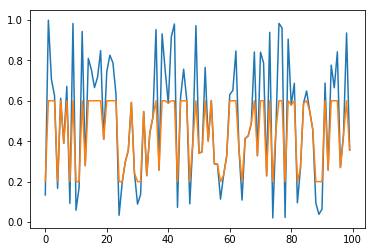

In [67]:
plt.plot(yyr)
plt.plot(yrr)

In [147]:
# Start with the subregion
time_sub_sub = time_sub[1180:3300]

# Get the time features of the subregion: map the interval to [0,1]
tss_diff = time_sub_sub[-1]-time_sub_sub[0]
T_max = time_sub_sub[-1]
T_min = time_sub_sub[0]
t_score = lambda t: (T_max-t)/(T_max-T_min)

# Get the matrix of stddevs 
# * find the min & max to rescale the interval
# * rescale to also include time-weights 
#S = lil_matrix((len(time_sub_sub),len(time_sub_sub)))
shape = (len(time_sub_sub),len(time_sub_sub))
S = np.empty(shape=shape)
S.fill(np.nan)



t0 = time()
# Get the min and max of the matrix-stds
'''
for row in range(1,len(time_sub_sub)-1):        
    for col in range(row+1,len(time_sub_sub)):  
''' 
'''smin=100
for row in range(1,100):        
    for col in range(row+1,100):  
        
        S[row,col] = np.std(noise_journey_sub[row:col+90])
        smin = min(smin,S[row,col])
    if row%100==0: 
        t1 = time()
        print(f'at row {row}, Dt = ', (t1-t0)/1, smin)
        t0 =t1     
        
print(smin)       
# Get the cluster spreads of the subregion: map the interval to [0,1]
S_max = S.todense().max() #S.max()
S_min = S.todense().min() #S.min()        
s_score = lambda s: s/(S_max-S_min)
print(S_min,smin)
'''
s_score = lambda s: s_metric(s,5*eps,eps)

t0 = time()

# Recompute the matrix;
'''
for row in range(1,len(time_sub_sub)-1):
    for col in range(row+1,len(time_sub_sub)):
'''        
'''for row in range(100):        
    for col in range(row+1,100):          
'''        
for row in range(1,len(time_sub_sub)-1):        
    for col in range(row+1,len(time_sub_sub)):  
        
        delta_t = abs(time_sub[row+1180]-time_sub[col+1180])
        tscore = t_score(delta_t)
        #tscore = t_score(abs(time_sub_sub[row]-time_sub_sub[col+90]))
        
        ss = np.std(noise_journey_sub[row+1180:col+1180])
        sscore = s_score(ss) # = np.std(noise_journey_sub[row:col])
        
        if delta_t < time_thresh:
            #print(row,col,delta_t)
            S[row,col] = np.nan
        else:
            S[row,col] = np.log(norm([sscore,tscore]))
            
    if row%100==0: 
        t1 = time()
        print(f'at row {row}, Dt = ', (t1-t0)/1)
        t0 =t1           

at row 100, Dt =  9.823669910430908
at row 200, Dt =  8.9223153591156
at row 300, Dt =  12.909716129302979
at row 400, Dt =  12.975362062454224
at row 500, Dt =  12.335509061813354
at row 600, Dt =  11.304881811141968
at row 700, Dt =  11.236873626708984
at row 800, Dt =  10.339955568313599
at row 900, Dt =  9.76880431175232
at row 1000, Dt =  8.939277648925781
at row 1100, Dt =  8.423980236053467
at row 1200, Dt =  7.188380718231201
at row 1300, Dt =  6.436681747436523
at row 1400, Dt =  5.6446826457977295
at row 1500, Dt =  4.878158807754517
at row 1600, Dt =  4.226213216781616
at row 1700, Dt =  3.36081600189209
at row 1800, Dt =  2.7734599113464355
at row 1900, Dt =  2.01776385307312
at row 2000, Dt =  1.2712085247039795
at row 2100, Dt =  0.4488406181335449


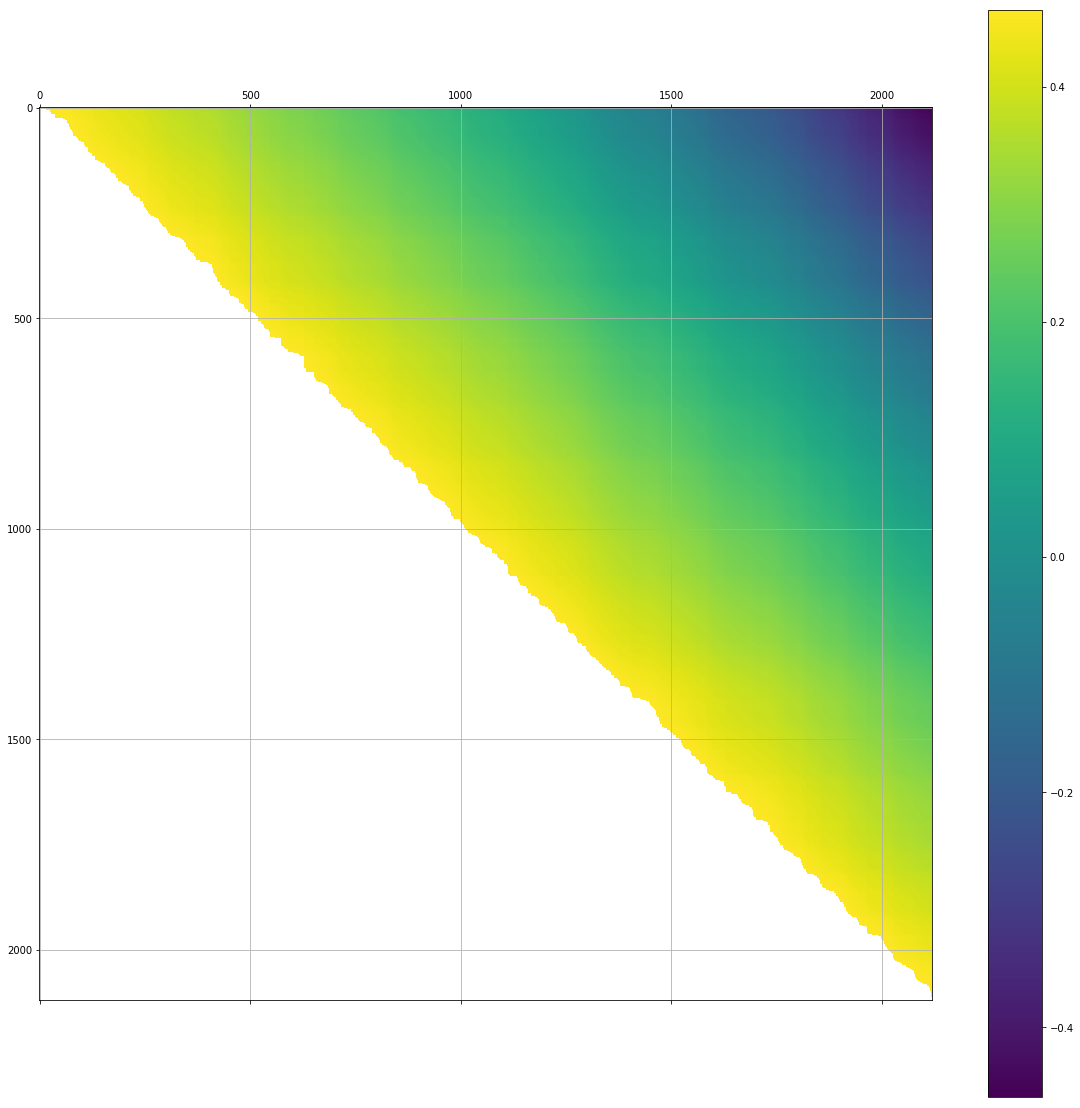

In [148]:

#plt.figure(figsize=[20,20])
fig, ax = plt.subplots(1,1,figsize=[20,20])
thing = ax.matshow(S)#, vmin=0,vmax=.2)
#fig.colorbar()
plt.colorbar(thing)
plt.grid()

```
print(smin)       
# Get the cluster spreads of the subregion: map the interval to [0,1]
S_max = np.nanmax(S) #S.max()
S_min = np.nanmin(S) #S.min()        
s_score = lambda s: s/(S_max-S_min)
print(S_min,smin)
```

In [149]:
np.where(S==np.nanmin(S))

(array([1, 1]), array([2118, 2119]))

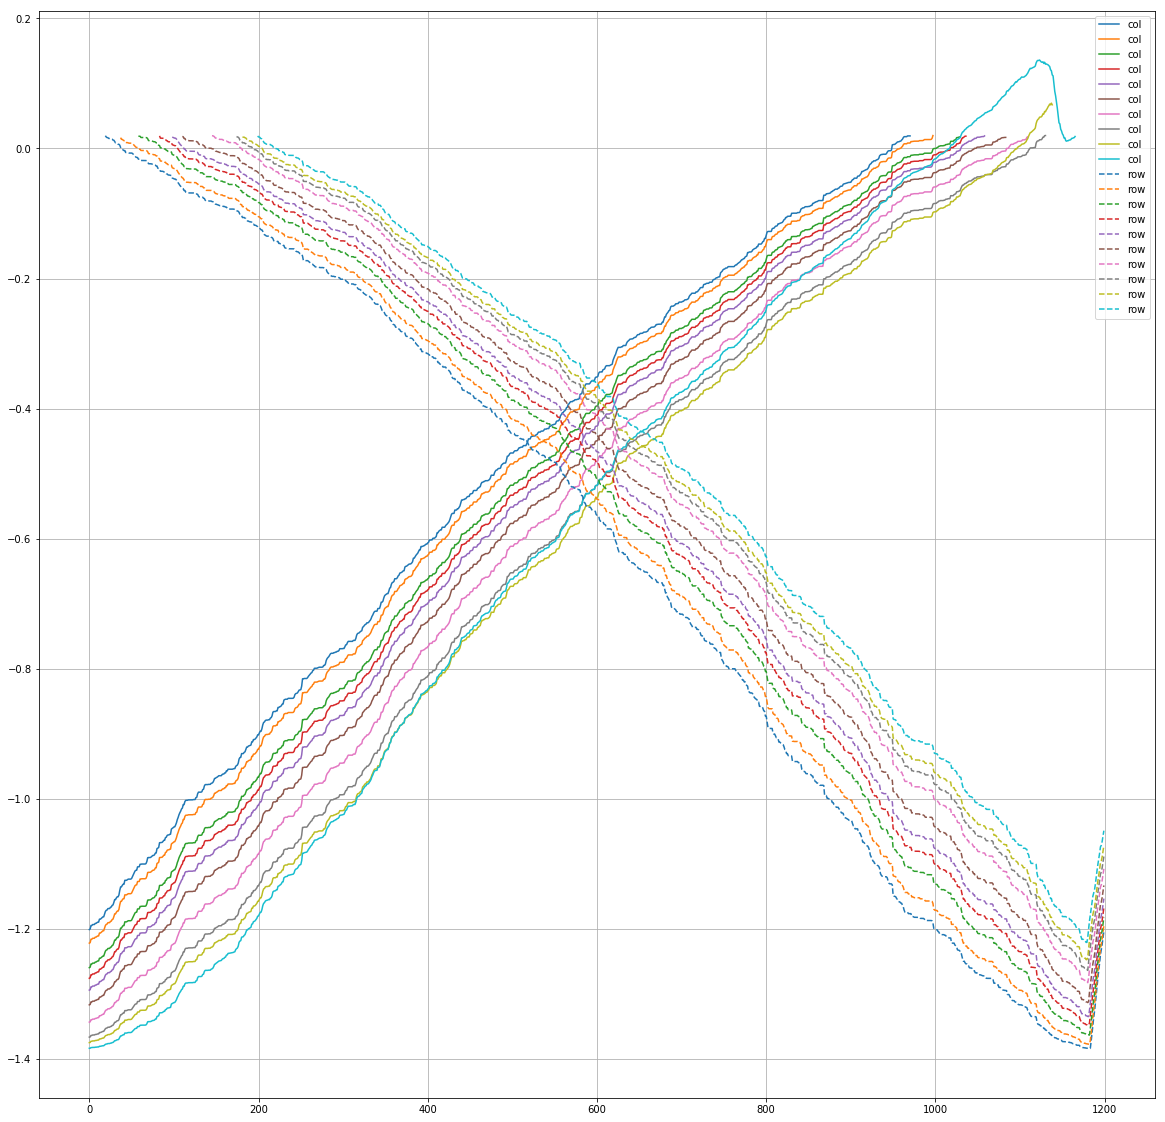

In [135]:
plt.figure(figsize=[20,20])
plt.plot(S[1:,1000:1200:20], label='col')#, vmin=0,vmax=.2)
plt.plot(S[1:200:20,:].transpose(), linestyle='--', label='row')#, vmin=0,vmax=.2)

#plt.colorbar()
plt.grid()
plt.legend();

### NOTES:

#### Deinfing time ranges
If the time range for the normalization is defined as such:
```
tss_diff = time_sub[1200]-time_sub[800]
T_max = time_sub[1200]
T_min = time_sub[800]
t_score = lambda t: (T_max-t)/(T_max-T_min)
```
then the problem is that there is an implicit definition that the exact length of time is known _and hence the stay is known!!!_
* can put an upper bound which will default to the max allowed duration for the segment, hoping that the deviations will reduce to the correct one
* dropping the time normalization from the computation would ignore trying to get temporally longer segments

#### Deifning the loc. ranges
Using a truncated range for the std calculation is faster without a loss in accuracy due to the limited nature of the data: anything below eps should be considered very random and anything above should be enough to give a cutoff
`s_score = lambda s: s_metric(s,5*eps,eps)`
* this will have the effect of taming the outliers
    * can get a segment mean and find the max dev. first, expecting that the mean shouldn't change too much.

In [112]:
s_score(0.15)

0.25

In [116]:
# Get the time features of the subregion: map the interval to [0,1]
tss_diff = time_sub[1200]-time_sub[800]
T_max = time_sub[1200]
T_min = time_sub[800]
t_score = lambda t: (T_max-t)/(T_max-T_min)

for n in range(800,1220,20):
    
    tscore = t_score(abs(time_sub[0]-time_sub[n]))
    #tscore = t_score(abs(time_sub_sub[row]-time_sub_sub[col+90]))

    ss = np.std(noise_journey_sub[0:n])
    sscore = s_score(ss) # = np.std(noise_journey_sub[row:col])
    
    sscore = np.log(norm([sscore,tscore]))
    print(n, tscore, ss, sscore)


800 1.004399748585795 0.13039628890434046 0.03444523210271608
820 0.9360150848522938 0.13045371668383876 -0.03167002562357311
840 0.8931489629164046 0.1301213979610649 -0.07528641982622246
860 0.8448774355751099 0.13070764989432063 -0.12659660101464598
880 0.7954745443117534 0.13065155911043672 -0.18172049774418927
900 0.7573852922690131 0.12990644946333282 -0.22617421698042536
920 0.6983029541169075 0.12974741768426734 -0.2988030448648121
940 0.6262727844123192 0.1290913512015427 -0.39403935548538527
960 0.5632935260842235 0.12885208890291072 -0.4840557714655047
980 0.5288497800125705 0.12890179018888315 -0.5362061286179055
1000 0.4983029541169071 0.12932690647487022 -0.5842934447441923
1020 0.4636077938403517 0.12909715287557463 -0.6410893742991267
1040 0.397862979258328 0.12919512378155779 -0.7552604175102332
1060 0.36756756756756714 0.1287210032022957 -0.8107402755817615
1080 0.3318667504714013 0.12849251623094307 -0.8782863057575938
1100 0.2837209302325579 0.12873541456756107 -0.9

In [80]:
S[np.where(np.isnan(S)==False)].min()

-0.11244210582155334

In [81]:
S_min = S[np.where((np.isnan(S)==False))].min()
row, col = np.where(S==S_min)
row = row[0]
col = col[0]

In [85]:
row,col

(1, 99)

ZeroDivisionError: integer division or modulo by zero

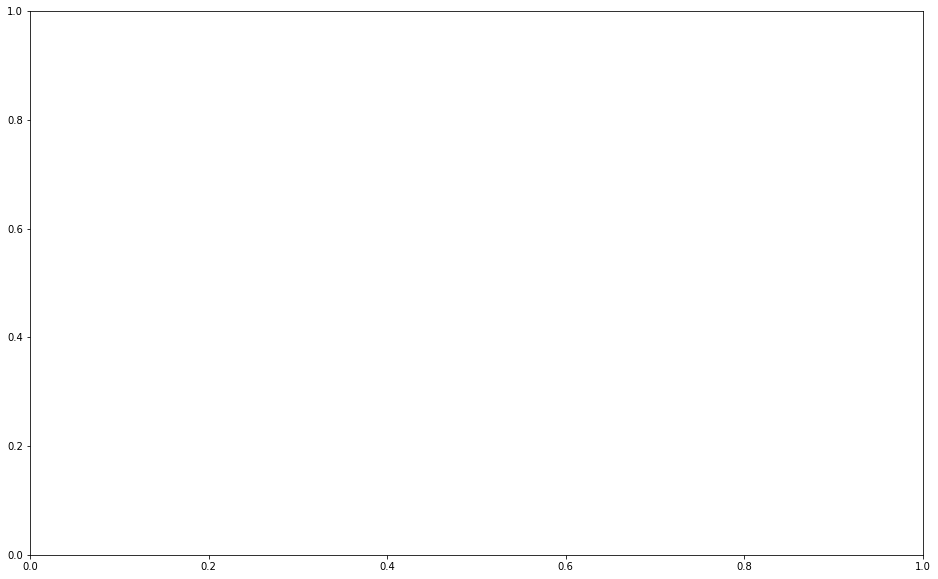

In [84]:
plt.figure(figsize=[16,10])
plt.plot(S[row-2:row+3,:].transpose())
plt.plot(S[:,col-2:col+3])
plt.grid()

In [ ]:
def get_stay_indices(time_arr, locs_arr, mask):

    # get the working subarrays
    t_subarr = time_arr[mask]
    x_subarr = locs_arr[mask]
    
    # Get the time features of the subregion: map the interval to [0,1]
    tss_diff = t_subarr[-1]-t_subarr[0]
    T_max = t_subarr[-1]
    T_min = t_subarr[0]
    t_score = lambda t: (T_max-t)/(T_max-T_min)

    # Get the matrix of stddevs (find the min & max to rescale the interval)
    #S = lil_matrix((len(t_subarr),len(t_subarr)))
    
    s = 0.0
    S_max = 0
    S_min = 100
    for row in range(1,len(t_subarr)-1):        
        for col in range(row+1,len(t_subarr)):           
            s = np.std(x_subarr[row:col])
            S_max=max(S_max, s)
            S_min=min(S_min, s)        

    # Get the cluster spreads of the subregion: map the interval to [0,1]    
    s_score = lambda s: s/(S_max-S_min)

    total_min = 10
    coords = [0,72]
    # Recompute the matrix;
    for row in range(1,len(t_subarr)-1):
        for col in range(row+1,len(t_subarr)):        
            tscore = t_score(abs(t_subarr[row]-t_subarr[col]))        
            sscore = s_score(np.std(x_subarr[row:col]))        
            s = norm([sscore,tscore])

            if s <= total_min:
                coords = [row,col]
                total_min = s

    #local coords of subarray
    #print(s,coords) 
    #global coords of the main array
    #NOTE: in the event of multiple events at the same time, 
    #      take the earliest from the beginning and the latest from the end
    return [np.where(time_arr==t_subarr[coords[0]])[0].min(),
            np.where(time_arr==t_subarr[coords[1]])[0].max()]

In [ ]:
stay_mask = get_stay_indices(time_sub,noise_journey_sub, np.arange(0,72))

In [ ]:
stay_mask


In [ ]:
i=2
j=65
x_inds = [j]
y_inds = [i]
for n in range(120):

    s = S[i,j]
    dn  = S[i-1,j]
    dne = S[i-1,j+1]
    de  = S[i,j+1]
    dse = S[i+1,j+1]
    ds  = S[i+1,j]
    dsw = S[i+1,j-1]
    dw  = S[i,j-1]
    dnw = S[i-1,j-1]

    dn  = dn  - s 
    dne = dne - s 
    de  = de  - s 
    dse = dse - s 
    ds  = ds  - s 
    dsw = dsw - s 
    dw  = dw  - s 
    dnw = dnw - s 

    dir_dict = {
        0:[-1,0],
        1:[-1,1],
        2:[0,1],
        3:[1,1],
        4:[1,0],
        5:[1,-1],
        6:[0,-1],
        7:[-1,-1]
    }

    dirs = [dn, dne, de, dse, ds, dsw, dw, dnw]
    
    #print(dirs,min(dirs))
    ind = dirs.index(min(dirs))
    
    i,j = np.array((i,j))+np.array(dir_dict[ind]).tolist()
    x_inds.append(j)
    y_inds.append(i)
    print(n,round(s,3),ind,i,j)

In [ ]:
plt.figure(figsize=[20,20])

plt.imshow(S.todense())#, vmin=0,vmax=.2)

plt.colorbar()

plt.plot(x_inds,y_inds,'r.-')
plt.grid()

In [ ]:
def get_batch_clusters2(times, locs, dist_thresh, time_thresh):

    
    # Get the max length of any cluster
    max_len = locs.size-6
    
    # The list of found clusters
    clusters = []

    # global indexing var
    ind = 0
    
    # Current cluster: a list of indices
    cluster = [0]
    
    # the last time point of a given cluster
    last_time_point = times[cluster[0]]

    # local indexing var
    m = 0 
    
    # iterate through the elements
    continuing = True
    while continuing:
        
        # Set the time buffer around the last point of the current cluster
        # look for the next temporally connected event
        # NOTE: _all_ events can be connected if the samp. freq. is high enough!
        # TODO: try something else!!!
        nn=m+1
        check_norm = True
        while check_norm:
            

            cluster_std = np.std(locs[m:nn])
            cluster_qstd = get_iqr_std(locs[m:nn])            
            cluster_qavg = get_iqr_avg(locs[m:nn])            
            
            tval = get_normd_err(times[nn], last_time_point, time_thresh)
            xval = get_normd_err(locs[nn], centroid, dist_thresh):            
            
            nn+=1

        #print(m,nn, locs[m:nn].shape)
        
        if locs[m:nn].size > 1:
            
            # Get the current cluster std
            cluster_std = np.std(locs[m:nn])
            cluster_qstd = get_iqr_std(locs[m:nn])
            
        else:
            cluster_std = 0.0
            cluster_qstd = 0.0
        
        nnn=nn
        while ((locs[m:nnn].size > 1) & \
              ((cluster_std >= dist_thresh) | \
               (cluster_qstd >= dist_thresh))):
            print('\t\trefinement', nnn, cluster_std, cluster_qstd)
            # Get the current cluster std
            cluster_std = np.std(locs[m:nnn])
            cluster_qstd = get_iqr_std(locs[m:nnn])
            nnn-=1

        # Check!
        print('STD-testing at', nn, cluster_std, cluster_qstd, dist_thresh)
        # 
        new_cluster = list(range(m,nnn+1))

        # if the std's are good, keep the cluster, and update the final time point
        if  (cluster_std < dist_thresh) & (cluster_qstd < dist_thresh) & (nnn<max_len) & (nnn==nn) :

            last_time_point = times[nnn]
            ind = nnn

        else:
            txt = f'Trying {len(new_cluster)} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            print(txt+app)

            new_cluster = []
            if (nnn==nn):
                ind=nn
                m=nn
            else:
                ind=nnn
                m=nnn
                
        if ind < max_len: continuing = False
            
    return clusters

In [ ]:
clusters = get_batch_clusters(time_sub,noise_journey_sub,eps,time_thresh)
len(clusters)

In [ ]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [ ]:
shuffle(colors)

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')


iqr_points_kwargs={'marker':'o', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':8.0, 'alpha':0.95, 
                   'label':'label'}

all_points_kwargs={'marker':'.', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':4.0, 'alpha':0.95, 
                   'label':'label'}

    
def get_new_kwargs(kwargs_dct):
    
    def meth(color, label):
        kwargs_dct.update({'color':color,'label':label})
        return kwargs_dct
    return meth
        
pdf = pd.DataFrame()
pdf_all = pd.DataFrame({'x':time_sub,'y':noise_journey_sub})

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr]   
    
    xs = time_sub[clust]
    ys = noise_journey_sub[clust]
    
    label=f'clust. Nr. {cl_nr}'
    plt.plot(xs, ys, **get_new_kwargs(all_points_kwargs)(color,label))
    
    label=f'clust. Nr. {cl_nr} (IQR)'
    mask=get_iqr_masked(ys,1)
    plt.plot(xs[mask], ys[mask], **get_new_kwargs(iqr_points_kwargs)(color,label))

    pdf1  = pd.DataFrame({'x':xs[mask],'yy':ys[mask]})
    #pdf2  = pd.DataFrame({'x':rxs[rmask],'y':rys[rmask]})
    #pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    pdf = pd.concat([pdf,pdf1])

# plot the rest of the samples
pdf_all = pdf_all.merge(pdf, on=['x'], how='outer')
pdf_all['keep'] = pdf_all.yy.apply(np.isnan)
pdf_sub = pdf_all[pdf_all['keep']]
plt.plot(pdf_sub.x.values, pdf_sub.y.values, alpha=0.95, linestyle='',color='k', marker='x', markersize=10.0, markeredgewidth=0.40, linewidth=0.50, label='Original trajectory')

plt.legend();

In [ ]:
clusters_rev = get_batch_clusters(np.max(time_sub)-time_sub[::-1],noise_journey_sub[::-1], eps,time_thresh)
len(clusters_rev)

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')

for cl_nr, clust in enumerate(clusters_rev):
    
    xs = time_sub[::-1][clust]
    ys = noise_journey_sub[::-1][clust]
    
    plt.plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    iqr_fact = 0
    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    plt.plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    
plt.legend();

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax = ax.reshape(2,)

ax[0].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[1].plot(time_sub, raw_journey_sub, '--', label='smooth profile')


for cl_nr, clust in enumerate(clusters):
    
    xs = time_sub[clust]
    ys = noise_journey_sub[clust]
    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    ax[0].plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
for cl_nr, clust in enumerate(clusters_rev[::-1]):

    xs = time_sub[::-1][clust]
    ys = noise_journey_sub[::-1][clust]
    
    print(xs[0],xs[-1])    
    xs = xs[::-1]
    print(xs[0],xs[-1])
    
    ys = ys[::-1]
    ax[1].plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    ax[1].plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();

In [ ]:
loc = 2.0
sig = 0.95
size = 250
unbalance_factor = 0.80 # change the location of the two spikes
test_1 = np.random.normal( loc,1*sig, int(size*unbalance_factor))
test_2 = np.random.normal(-loc,1.5*sig, int(size/unbalance_factor))
test_3 = np.random.normal( loc,2*sig, size)
test_4 = np.random.normal(-loc,4*sig, size)
test = np.concatenate((test_1,test_2, test_3, test_4))

np.random.shuffle(test)

mask = get_iqr_masked(test, iqr_fact = 1.1)

inds = np.arange(len(test))

fig, ax = plt.subplots(1,2, figsize=(20,8))

ax =ax.reshape(2)
#plt.plot(test_1)
#plt.plot(test_2)
ax[0].plot(inds, test, '.-')
ax[0].plot(inds[mask], test[mask], 'o')
ax[0].set_xlim(0,200)

_ = ax[1].hist(test, bins=np.arange(-15,15.25,0.25))

## Notes
* need to ensure the time-backward trajectory works in roughly the same way as the time-forward one
* need to have something that merges nearby clusters if they are close enough in time and space

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(20,15))
ax = ax.reshape(3,)

ax[0].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[1].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[2].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[2].plot(time_sub, noise_journey_sub, '.', alpha=0.95, color='k', markersize=4.0, label='outliers')    


get_match = lambda x,y: (np.isnan(x) | np.isnan(x))
get_val = lambda x,y: x if np.isnan(x)==False else y

cl_nr = 0

for clust, rclust in zip(clusters,clusters_rev[::-1]):
    
    xs = time_sub[clust]
    ys = noise_journey_sub[clust]
    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    ax[0].plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
    pdf1  = pd.DataFrame({'x':xs[mask],'y':ys[mask]})

    
    rxs = time_sub[::-1][rclust]
    rys = noise_journey_sub[::-1][rclust]
    
    print(xs[0],xs[-1])    
    rxs = rxs[::-1]
    print(xs[0],xs[-1])
    
    rys = rys[::-1]
    ax[1].plot(rxs, rys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    rmask=np.where((rys > (q25 - iqr_fact * iqr)) & (rys < (q75 + iqr_fact * iqr)))
    
    ax[1].plot(rxs[rmask], rys[rmask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();
    
    pdf2  = pd.DataFrame({'x':rxs[rmask],'ry':rys[rmask]})    
    
    pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    #pdf = pd.concat([pdf,pdf1.merge(pdf2, on=['x'], how='outer')])
    
    pdf['matched'] = pdf.apply(lambda x: get_match(x['y'],x['ry']), axis=1)
    pdf['yy'] = pdf.apply(lambda x: get_val(x['y'],x['ry']), axis=1)

    
    ax[2].plot(pdf[pdf['matched']==False].x.values, pdf[pdf['matched']==False].y.values, 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    #ax[2].plot(pdf[pdf['matched']].x.values, pdf[pdf['matched']].yy.values, '.', alpha=0.95, color='k', markersize=4.0, label=None)


    ax[2].legend();    
    
    cl_nr += 1

### Div.&Conq. MaxSubArray codes

In [ ]:
#See https://www.geeksforgeeks.org/maximum-sum-subarray-using-divide-and-conquer-set-2/?ref=rp
# Python3 implementation of the approach  
  
class Node:  
      
    def __init__(self, x): 
          
        # To store the maximum sum for a sub-array  
        self._max = x 
          
        # To store the maximum prefix sum for a sub-array 
        self._pre = x 
          
        # To store the maximum suffix sum for a sub-array 
        self._suf = x 
          
        # To store the total sum for a sub-array 
        self._sum = x 
          
# Function to merge the 2 nodes left and right  
def merg(l, r):  
      
    # Creating node ans  
    ans = Node(0)  
  
    # The max prefix sum of ans Node is maximum of  
    # a) max prefix sum of left Node  
    # b) sum of left Node + max prefix sum of right Node  
    # c) sum of left Node + sum of right Node  
    ans._pre = max(l._pre, l._sum+r._pre, l._sum+r._sum)  
  
    # The max suffix sum of ans Node is maximum of  
    # a) max suffix sum of right Node  
    # b) sum of right Node + max suffix sum of left Node  
    # c) sum of left Node + sum of right Node  
    ans._suf = max(r._suf, r._sum+l._suf, l._sum+r._sum)  
      
    # Total sum of ans Node = total sum of  
    # left Node + total sum of right Node  
    ans._sum = l._sum + r._sum  
      
    # The max sum of ans Node stores the answer 
    # which is the maximum value among:  
    # prefix sum of ans Node  
    # suffix sum of ans Node  
    # maximum value of left Node  
    # maximum value of right Node  
    # prefix value of left Node + suffix value of right Node  
    ans._max = max(ans._pre, ans._suf, ans._sum, 
                    l._max, r._max, l._suf+r._pre)  
  
    # Return the ans Node  
    return ans  
  
# Function for calculating the  
# max_sum_subArray using divide and conquer  
def getMaxSumSubArray(l, r, ar):  
  
    if l == r: return Node(ar[l])  
  
    mid = (l + r) // 2
      
    # Call method to return left Node:  
    left = getMaxSumSubArray(l, mid, ar)  
      
    # Call method to return right Node:  
    right = getMaxSumSubArray(mid+1, r, ar)  
      
    # Return the merged Node:  
    return merg(left, right)  
  
# Driver code  
if __name__ == "__main__": 
  
    ar = [-2, -5, 6, -2, -3, 1, 5, -6]  
    n = len(ar)  
    ans = getMaxSumSubArray(0, n-1, ar)  
    print("Answer is", ans._max) 
  
# This code is contributed by Rituraj Jain 
